In [10]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.stats import ranksums

import glob
import os
import matplotlib.pyplot as plt

from modules.utilities import *
from modules.constants import *
from modules import CliffsDelta
from scipy.stats import shapiro
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

plt.rcParams.update(mpl_params)
pio.templates.default = "custom_matplotlib_like"

TOPIC_DIR = "./Outputs/BERTopic/Topics"
DATA_DIR = "./Outputs/PerformancePRs"

In [11]:
topics = {}
for topic_file in glob.glob(os.path.join(TOPIC_DIR, "*.csv")):
    if "-1" not in topic_file:
        topic_name = os.path.basename(topic_file).replace(".csv", "")
        df = pd.read_csv(topic_file)
        topics[topic_name] = df

In [12]:
total_prs = sum([len(df) for df in topics.values()])
print(f"Total PRs across all topics: {total_prs}")

Total PRs across all topics: 1120


In [13]:
category_dfs = {}
for category, topic_list in category_map.items():
    dfs_to_concat = []
    for topic in topic_list:
        df = topics[topic].copy()
        df['topic_name'] = topic_map.get(topic, topic)
        df['category'] = category
        dfs_to_concat.append(df)
    
    if dfs_to_concat:
        category_dfs[category] = pd.concat(dfs_to_concat, ignore_index=True)

total = 0
for category, df in category_dfs.items():
    total += len(df)
    print(f"{category}: {len(df)} PRs")
print(f"Total PRs across all categories: {total}")

Development: 222 PRs
Low-level: 257 PRs
UI: 136 PRs
Caching: 87 PRs
Algorithmic: 119 PRs
Query: 61 PRs
Networking: 96 PRs
Analytics: 61 PRs
Hardware: 49 PRs
AI: 32 PRs
Total PRs across all categories: 1120


In [14]:
all_categories_df = pd.concat(category_dfs.values(), ignore_index=True)

In [15]:
all_categories_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0,1.0,False,CI/CD,Development
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0,1.0,False,CI/CD,Development
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0,1.0,False,CI/CD,Development
3,3074681764,13829,Update build documentation with quick build op...,This PR updates the build documentation (`tool...,Copilot,198982749,Copilot,open,2025-05-19T18:25:04Z,NaN,NaN,281765424,https://api.github.com/repos/microsoft/azurelinux,https://github.com/microsoft/azurelinux/pull/1...,0,1.0,False,CI/CD,Development
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0,1.0,False,CI/CD,Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,3144466175,4,Implement local storage persistence,"A new persistence utility, `src/lib/persistenc...",Cursor,56125930,f1shy-dev,closed,2025-06-13T18:49:45Z,2025-06-13T18:49:52Z,2025-06-13T18:49:52Z,998301272,https://api.github.com/repos/intern3-chat/inte...,https://github.com/intern3-chat/intern3-chat/p...,48,1.0,False,Chat System,AI
1116,3275952470,2777,fix: update schemaDesignTool to directly updat...,## Issue\n\n- resolve: Root cause issue where ...,Devin,158243242,devin-ai-integration[bot],open,2025-07-30T07:15:24Z,NaN,NaN,839216423,https://api.github.com/repos/liam-hq/liam,https://github.com/liam-hq/liam/pull/2777,48,1.0,True,Chat System,AI
1117,3074294403,320,Integrate chatAudioIO module,# Integrate chatAudioIO module\n\nThis PR inte...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-19T15:42:40Z,2025-05-28T14:33:26Z,NaN,374381865,https://api.github.com/repos/stack-chan/stack-...,https://github.com/stack-chan/stack-chan/pull/320,48,1.0,False,Chat System,AI
1118,3058809612,1399,Fix: Cache system info to prevent re-fetching ...,# Cache System Info to Prevent Re-fetching on ...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-13T05:33:38Z,2025-05-13T07:32:44Z,NaN,575321313,https://api.github.com/repos/langbot-app/LangBot,https://github.com/langbot-app/LangBot/pull/1399,48,1.0,False,Chat System,AI


In [16]:
closed_df = all_categories_df[all_categories_df['state'] == 'closed']
status = closed_df["merged_at"].apply(lambda x: 'Accepted' if pd.notna(x) else 'Rejected')
closed_df["status"] = status.to_list()
closed_df

/var/folders/fz/gkgx65n92ng3dbh3ypb6nxpc0000gn/T/ipykernel_10100/618948031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_df["status"] = status.to_list()


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category,status
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0,1.0,False,CI/CD,Development,Rejected
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0,1.0,False,CI/CD,Development,Accepted
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0,1.0,False,CI/CD,Development,Accepted
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0,1.0,False,CI/CD,Development,Rejected
5,3259387186,4471,Fix Gradle build failures due to Maven Central...,## Problem\n\nCI jobs were failing due to Mave...,Copilot,198982749,Copilot,closed,2025-07-24T10:28:36Z,2025-07-24T12:17:19Z,2025-07-24T12:17:19Z,511141524,https://api.github.com/repos/valkey-io/valkey-...,https://github.com/valkey-io/valkey-glide/pull...,0,1.0,False,CI/CD,Development,Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,3185789444,8605,feat(worker): Implement bulk event sending method,%23%23%23 What changed%3F Why was the change n...,Cursor,8872447,scopsy,closed,2025-06-29T05:51:20Z,2025-06-29T10:56:55Z,NaN,400215964,https://api.github.com/repos/novuhq/novu,https://github.com/novuhq/novu/pull/8605,48,1.0,False,Chat System,AI,Rejected
1115,3144466175,4,Implement local storage persistence,"A new persistence utility, `src/lib/persistenc...",Cursor,56125930,f1shy-dev,closed,2025-06-13T18:49:45Z,2025-06-13T18:49:52Z,2025-06-13T18:49:52Z,998301272,https://api.github.com/repos/intern3-chat/inte...,https://github.com/intern3-chat/intern3-chat/p...,48,1.0,False,Chat System,AI,Accepted
1117,3074294403,320,Integrate chatAudioIO module,# Integrate chatAudioIO module\n\nThis PR inte...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-19T15:42:40Z,2025-05-28T14:33:26Z,NaN,374381865,https://api.github.com/repos/stack-chan/stack-...,https://github.com/stack-chan/stack-chan/pull/320,48,1.0,False,Chat System,AI,Rejected
1118,3058809612,1399,Fix: Cache system info to prevent re-fetching ...,# Cache System Info to Prevent Re-fetching on ...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-13T05:33:38Z,2025-05-13T07:32:44Z,NaN,575321313,https://api.github.com/repos/langbot-app/LangBot,https://github.com/langbot-app/LangBot/pull/1399,48,1.0,False,Chat System,AI,Rejected


In [17]:
print("Rejected PRs:", closed_df[closed_df["status"] == "Rejected"].shape[0])
print("percentage Rejected PRs:", (closed_df[closed_df["status"] == "Rejected"].shape[0] / closed_df.shape[0]) * 100)
print("Accepted PRs:", closed_df[closed_df["status"] == "Accepted"].shape[0])
print("percentage Accepted PRs:", (closed_df[closed_df["status"] == "Accepted"].shape[0] / closed_df.shape[0]) * 100)

Rejected PRs: 360
percentage Rejected PRs: 36.54822335025381
Accepted PRs: 625
percentage Accepted PRs: 63.45177664974619


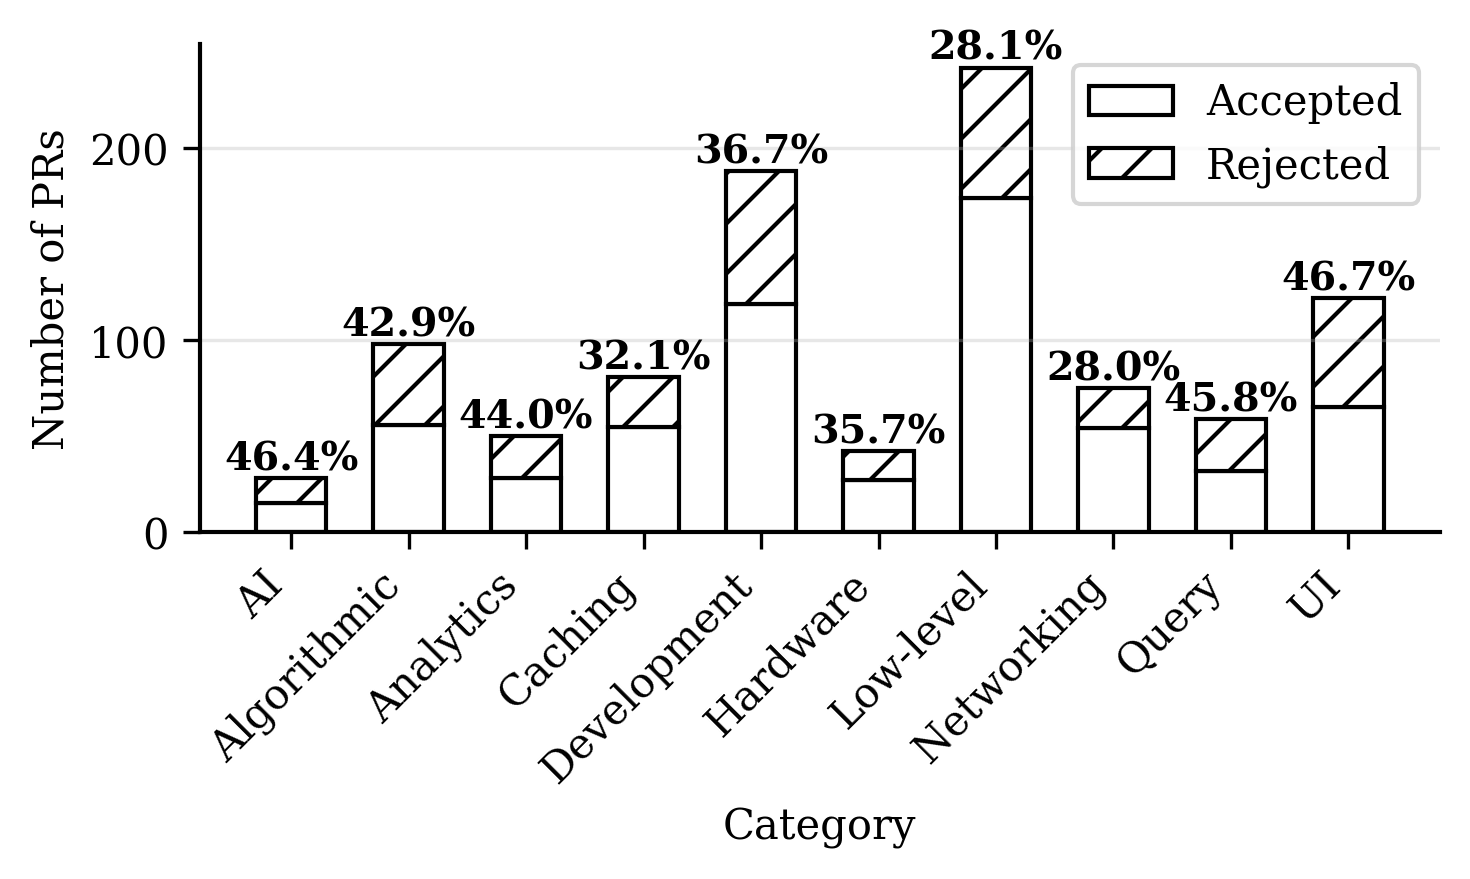

In [19]:
# Prepare data for stacked bar chart
grouped_data = closed_df.groupby(['agent', 'category', 'status'])['id'].nunique().reset_index(name='count')

# Get unique agents and categories
agents = sorted(closed_df['agent'].unique())
categories = sorted(closed_df['category'].unique())

# Prepare data for matplotlib
fig, ax = plt.subplots(figsize=(5, 3))

# Set up positions for bars
x_pos = np.arange(len(categories))
bar_width = 0.6

# Prepare data arrays for accepted and rejected
accepted_counts = []
rejected_counts = []

for category in categories:
    mask_accepted = (grouped_data['category'] == category) & (grouped_data['status'] == 'Accepted')
    mask_rejected = (grouped_data['category'] == category) & (grouped_data['status'] == 'Rejected')
    
    accepted = grouped_data[mask_accepted]['count'].sum() if mask_accepted.any() else 0
    rejected = grouped_data[mask_rejected]['count'].sum() if mask_rejected.any() else 0
    
    accepted_counts.append(accepted)
    rejected_counts.append(rejected)

# Create stacked bars
bars1 = ax.bar(x_pos, accepted_counts, bar_width, label='Accepted', color = "#ffffff",  edgecolor='black')
bars2 = ax.bar(x_pos, rejected_counts, bar_width, bottom=accepted_counts, color = "#ffffff", 
               label='Rejected', hatch='//', edgecolor='black')

# Add percentage labels for rejected PRs
for i, (accepted, rejected) in enumerate(zip(accepted_counts, rejected_counts)):
    total = accepted + rejected
    if total > 0:
        percentage = (rejected / total) * 100
        # Position label at the top of the bar
        ax.text(x_pos[i], total, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=9.5, fontweight='bold')

# Customize the plot
ax.set_xlabel('Category')
ax.set_ylabel('Number of PRs')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("./Outputs/Figures/RQ2_Accepted_Rejected_StackedBar.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()
